<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/060922_Exp_2_FSH_Bed_Occupancy_Forecast_TF_LSTM_Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import date
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None

In [2]:
#load the data
data = pd.read_csv('/content/fsh_bed.csv', parse_dates=['date'], index_col='date')
data = data[['occupancy']]

In [3]:
data.head()

,occupancy
date,
2016-01-01,0.85
2016-01-02,0.88
2016-01-03,0.91
2016-01-04,0.77
2016-01-05,0.79


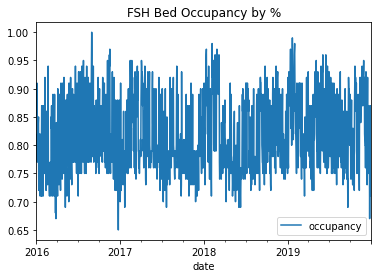

In [4]:
data.plot(title='FSH Bed Occupancy by %')

In [5]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
z = scaler.transform(data)

In [6]:
# extract the input sequences and target values
window_size = 60

x, y = [], []

for i in range(window_size, len(z)):
    x.append(z[i - window_size: i])
    y.append(z[i])

x, y = np.array(x), np.array(y)

In [7]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=x.shape[1:]))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam', metrics='mae')
model.fit(x, y, epochs=500, batch_size=64, verbose=1)

Epoch 1/500
22/22 [==============================] - 5s 72ms/step - loss: 0.0724 - mae: 0.2106
Epoch 2/500
22/22 [==============================] - 2s 71ms/step - loss: 0.0302 - mae: 0.1438
Epoch 3/500
22/22 [==============================] - 2s 71ms/step - loss: 0.0297 - mae: 0.1435
Epoch 4/500
22/22 [==============================] - 2s 70ms/step - loss: 0.0296 - mae: 0.1426
Epoch 5/500
22/22 [==============================] - 2s 70ms/step - loss: 0.0296 - mae: 0.1432
Epoch 6/500
22/22 [==============================] - 2s 72ms/step - loss: 0.0297 - mae: 0.1441
Epoch 7/500
22/22 [==============================] - 2s 71ms/step - loss: 0.0294 - mae: 0.1427
Epoch 8/500
22/22 [==============================] - 2s 70ms/step - loss: 0.0293 - mae: 0.1427
Epoch 9/500
22/22 [==============================] - 2s 70ms/step - loss: 0.0292 - mae: 0.1430
Epoch 10/500
22/22 [==============================] - 2s 70ms/step - loss: 0.0292 - mae: 0.1435
Epoch 11/500
22/22 [=============================

In [8]:
def multi_step_forecasts(n_past, n_future):

    x_past = x[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame
    df_past = data.rename(columns={'occupancy': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

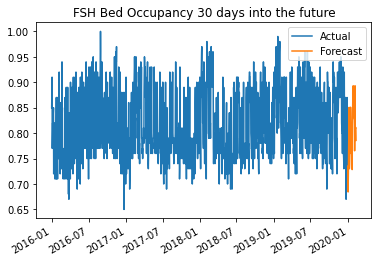

In [9]:
# forecast the next 30 days
df1 = multi_step_forecasts(n_past=0, n_future=30)
df1.plot(title='FSH Bed Occupancy 30 days into the future')

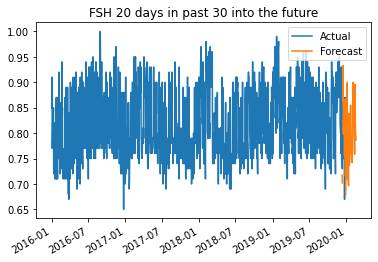

In [10]:
df2 = multi_step_forecasts(n_past=20, n_future=30)
df2.plot(title='FSH 20 days in past 30 into the future')